El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

In [1]:
#pip install missingno

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics
import sklearn.neighbors
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

import lightgbm as lgb
import xgboost as xgb

import missingno as msno
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


In [3]:
data = pd.read_csv("https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
#convertir a snake case
def snake_case(nombreColumna):
    nuevo_nombre = ''
    for caracter in nombreColumna:
        if caracter.isupper():
            nuevo_nombre += '_' + caracter.lower()
        else:
            nuevo_nombre += caracter
    return nuevo_nombre.lstrip('_')

data.rename(columns=snake_case, inplace=True)
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In [6]:
data.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


price
0     10772
1      1189
10       84
5        26
2        12
8         9
3         8
9         8
7         3
4         1
Name: count, dtype: int64


array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'registration_year'}>],
       [<Axes: title={'center': 'mileage'}>,
        <Axes: title={'center': 'power'}>]], dtype=object)

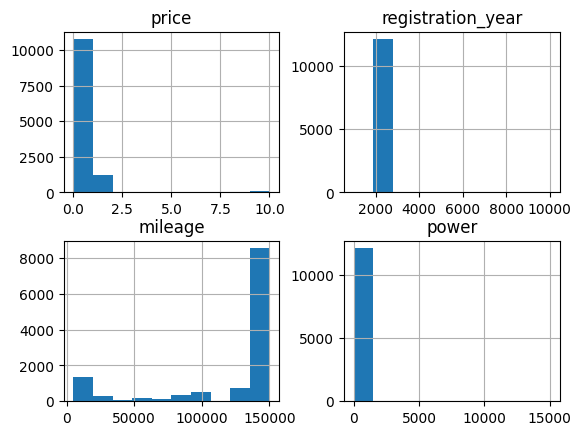

In [7]:
y_zero = data[data["price"]<=10]["price"].value_counts()
print(y_zero)
data[data["price"]<=10][["price", "registration_year", "mileage", "power"]].hist()

In [8]:
display(data.head(5))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


De primera mano podemos ver algunos pasos a seguir, el primero de ellos es la eliminación de la columna "number_of_pictures" ya que sus datos están en 0 y realmente no sirve de nada tenerla. Las columnas power, registration_year y price tienen valores atípicos, los descartaremos tomando en cuenta el contexto, la distancia intercuartil e histogramas para visualizar las distribuciones. Para la columna de price mantendremos estos valores ya que es nuestro target, solo eliminaremos los valores en 0 (son menos del 2%). Otro punto a considerar es que las columnas "date_crawled","date_created", "last_seen", "postal_code" y "registration_month" tienen valores que no suponen ninguna ayuda para nuestra característica objetivo, así que las eliminaremos para simplificar el modelo y mejorar la precisión por ser características irrelevantes o poco informativas.

In [9]:
#Eliminamos la características basura 
junk_data =  ["date_crawled","date_created", "last_seen", "postal_code", "registration_month", "number_of_pictures"]
data.drop(junk_data, axis=1, inplace=True)



In [10]:

iqrs = {
    'registration_year': {'Q1': 1999, 'Q3': 2008},
    'power': {'Q1': 69, 'Q3': 143},
    'mileage': {'Q1': 125000, 'Q3': 150000}
}

# iqr para cada columna
for col, values in iqrs.items():
    Q1 = values['Q1']
    Q3 = values['Q3']
    IQR = Q3 - Q1
    inf = Q1 - 1.5 * IQR
    sup = Q3 + 1.5 * IQR
    print(f"{col}: Límite inferior = {inf}, Límite superior = {sup}")



registration_year: Límite inferior = 1985.5, Límite superior = 2021.5
power: Límite inferior = -42.0, Límite superior = 254.0
mileage: Límite inferior = 87500.0, Límite superior = 187500.0


Al analizar los rangos, nos damos cuenta que para la columna año el limite superior se considera el 2021, al conocer el contexto de la columna, y desconocer el año en que se obtuvieron los datos, manejaremos el 2024 como limite superior, y respetaremos el limite inferior como corte. Con la columna power para algo parecido, aunque el limite superior obtuvimos un valor de 254 e inferior de -42, el contexto confirma que los valores reales de un vehiculo oscilan entre 80 y 400. Los datos de "mileage" lo dejaremos como están, aunque parezca que tienen un limite superior de 150000


In [11]:
#Descartamos valores atípicos
data = data[(data["registration_year"]<=2024) & (data["power"] >= 80) & (data["power"] <= 400)&(data["price"]>=10)]
display(data.describe())
display(data.head())

,price,registration_year,power,mileage
count,226617.000000,226617.000000,226617.000000,226617.000000
mean,5762.067546,2003.858073,139.471880,130005.913060
std,4810.323761,6.914274,46.795438,35693.093824
min,10.000000,1000.000000,80.000000,5000.000000
25%,1900.000000,2000.000000,105.000000,125000.000000
50%,4200.000000,2004.000000,131.000000,150000.000000
75%,8499.000000,2008.000000,163.000000,150000.000000
max,20000.000000,2019.000000,400.000000,150000.000000


,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN


<Axes: >

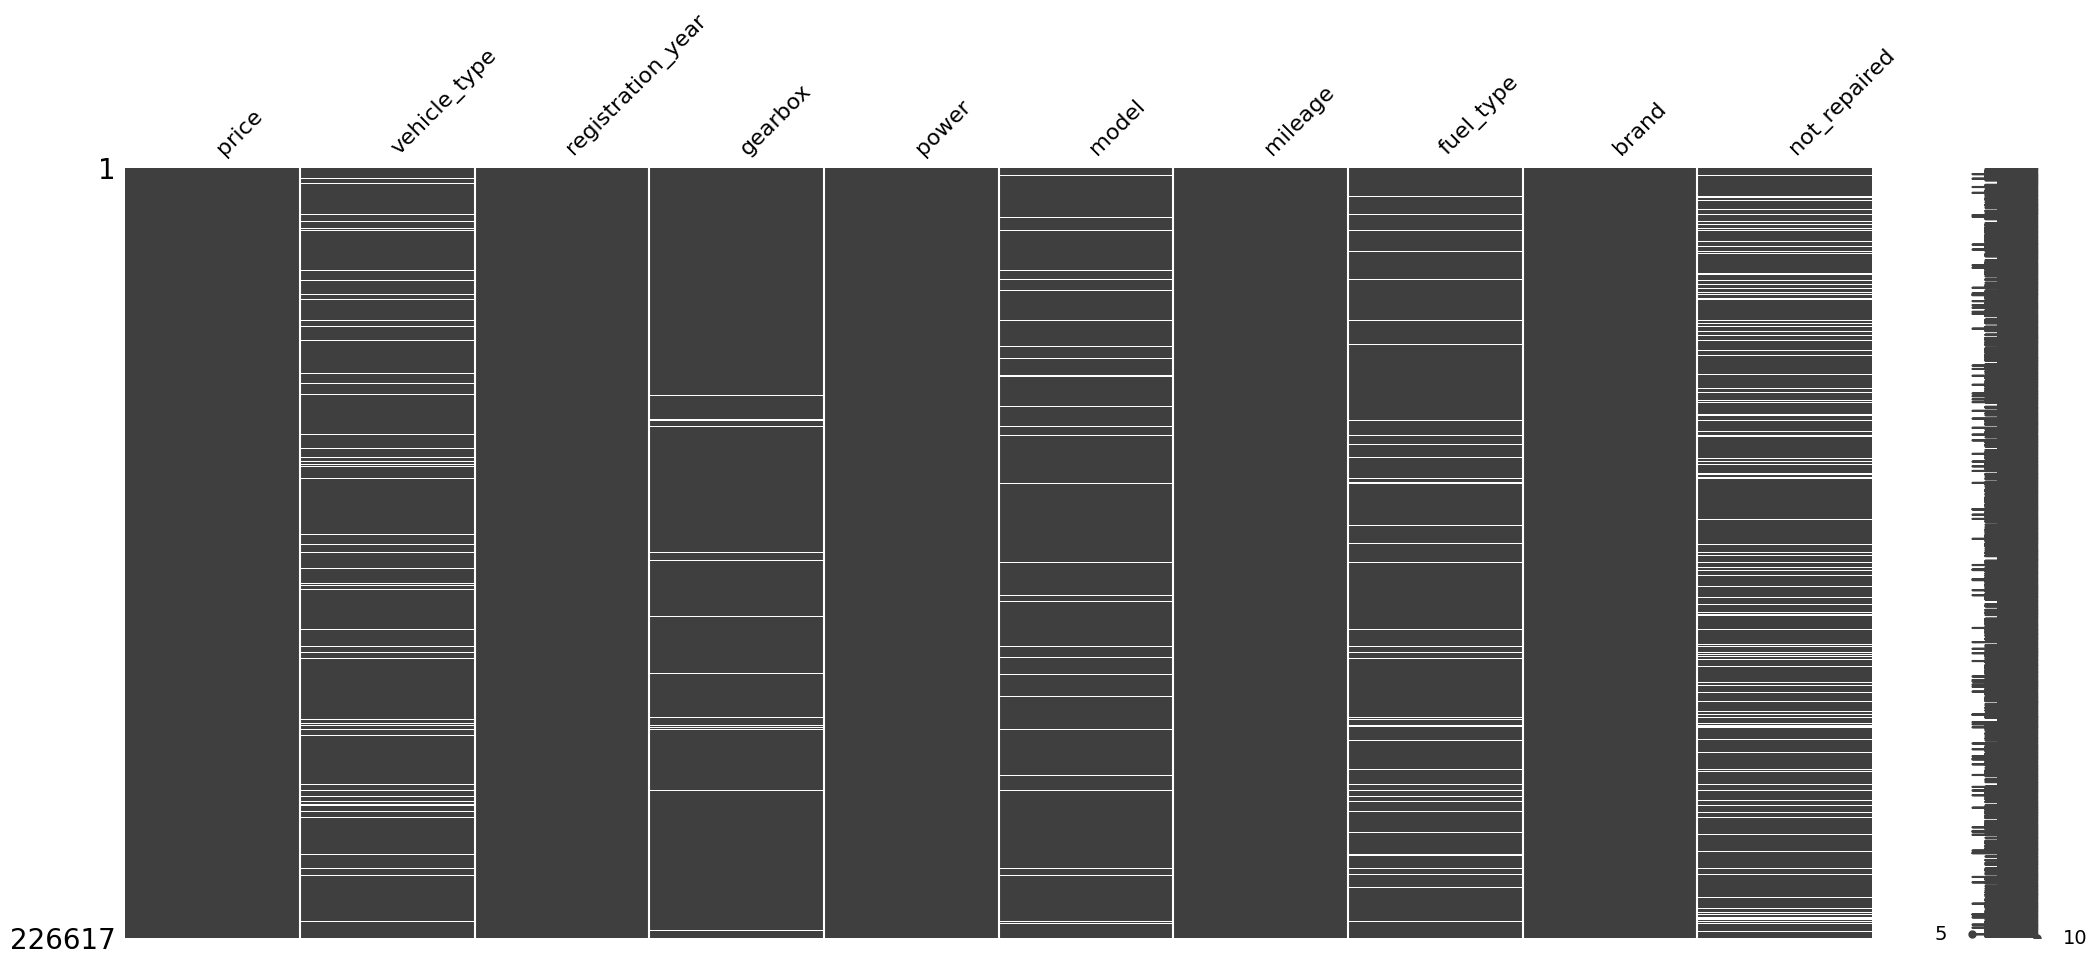

In [12]:
##Matriz de datos ausentes
msno.matrix(data)

Ahora comenzaremos a tratar los valores ausentes, para los casos de las caracteríticas "price","vehicle_type","registration_year","gearbox","model","fuel_type" y "brand" sus datos pueden tener alta correlacion entre ellos, ya que estamos hablando de un contexto de vehículos, así que usaremos un KNNimputer de scikit learn para imputar estos datos ausentes. Para el caso de la característica "not_repaired", no tenemos forma de averiguar si el vehiculo fue reparado o no, así que estableceremos estos valores como "unknown".

In [13]:
#imputación de unknown para not_repaired
data["not_repaired"].replace(np.nan, "unknown" , inplace=True)
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'mileage', 'fuel_type', 'brand', 'not_repaired'],
      dtype='object')

In [14]:
#Adecuación de características
categoric =["vehicle_type","gearbox","model","fuel_type","brand", "not_repaired"]
features = data.drop("price", axis=1)
target= data["price"]

df_encoded = pd.get_dummies(features, columns=categoric, drop_first=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_encoded)
df_scaled = pd.DataFrame(scaled_data, columns=df_encoded.columns, index=df_encoded.index)


#KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Imputar los valores faltantes
imputed_data = imputer.fit_transform(df_scaled)
df_preprocesed = pd.DataFrame(imputed_data, columns=df_scaled.columns, index=df_scaled.index)
df_preprocesed["price"] = target
#Integrar target a 
print("Valores NaN:", df_preprocesed.isna().sum().sum())
display(df_preprocesed.head())

Valores NaN: 0


,registration_year,power,mileage,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes,price
1,0.992149,0.343750,0.827586,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18300
2,0.985280,0.259375,0.827586,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9800
5,0.976447,0.068750,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,650
6,0.985280,0.090625,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2200
8,0.995093,0.140625,0.172414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14500


In [15]:
#msno.matrix(df_preprocesed)

## Entrenamiento del modelo 

In [16]:
np.random.seed(999)

x = df_preprocesed.drop("price", axis=1)
y = df_preprocesed["price"]

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state= 999)

#### REGRESION LINEAL

RMSE: 2777.87


c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


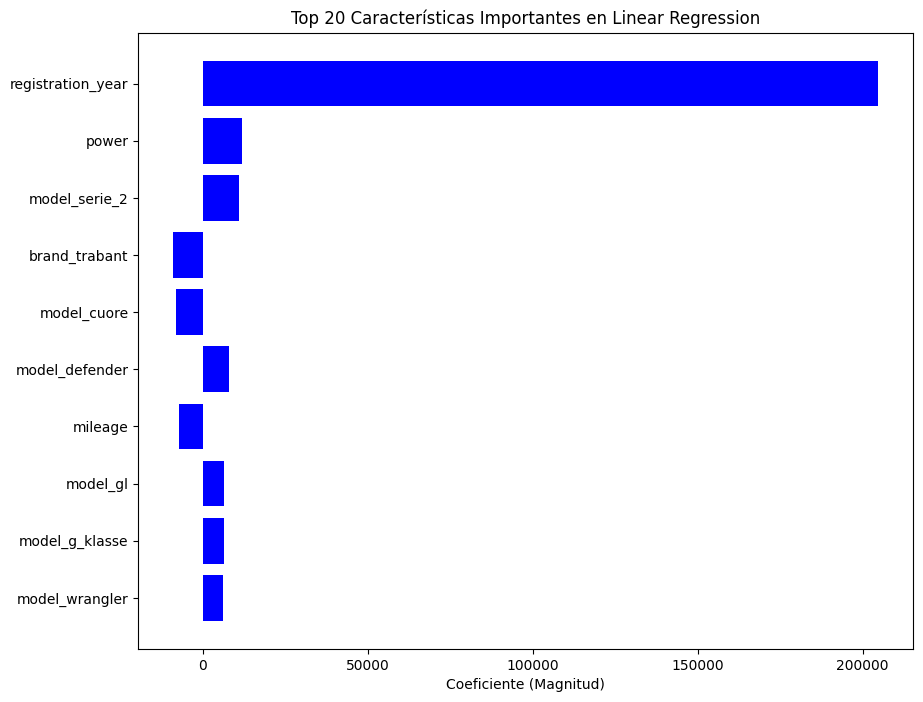

In [17]:
lr_model = LinearRegression()

lr_model.fit(x_train, y_train)
lr_predictions = lr_model.predict(x_valid)

rmse = sklearn.metrics.mean_squared_error(y_valid, lr_predictions, squared=False)
print(f'RMSE: {rmse:.2f}')

coefficients = lr_model.coef_

feature_names = x_train.columns

# Ordenar las características por la importancia absoluta de sus coeficientes
indices = np.argsort(abs(coefficients))[::-1]
top_n_indices = indices[:10]

# gráfico de barras para visualizar la importancia de las  características
plt.figure(figsize=(10, 8))
plt.title("Top 20 Características Importantes en Linear Regression")
plt.barh(range(10), coefficients[top_n_indices], color='b', align='center')
plt.yticks(range(10), [feature_names[i] for i in top_n_indices])
plt.xlabel("Coeficiente (Magnitud)")
plt.gca().invert_yaxis()  # Invertir el eje Y para que la característica más importante esté arriba
plt.show()


#### BOSQUE ALEATORIO

c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 1732.76


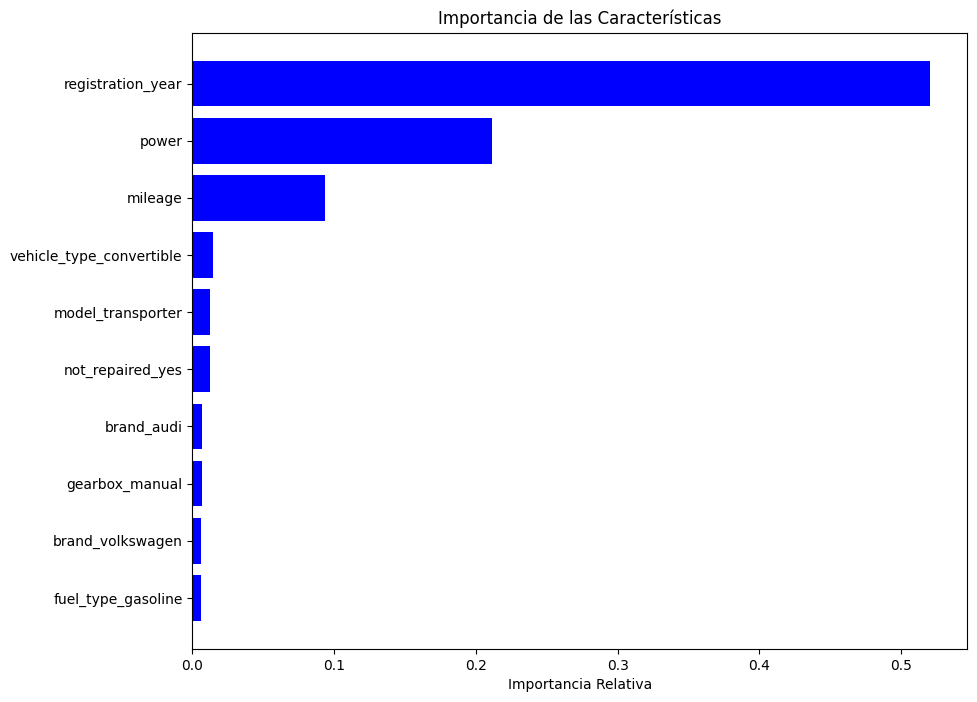

In [18]:
rf_model = RandomForestRegressor()

rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_valid)

rmse = sklearn.metrics.mean_squared_error(y_valid, rf_predictions, squared=False)
print(f'RMSE: {rmse:.2f}')

feature_importances = rf_model.feature_importances_
features = x_train.columns
indices = np.argsort(feature_importances)[-10:]


plt.figure(figsize=(10, 8))  
plt.title('Importancia de las Características')
plt.barh(range(len(indices)), feature_importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importancia Relativa')
plt.show()

#### LIGHTGBM

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1309.61	valid_0's l2: 3.72372e+06
RMSE: 1929.70


c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

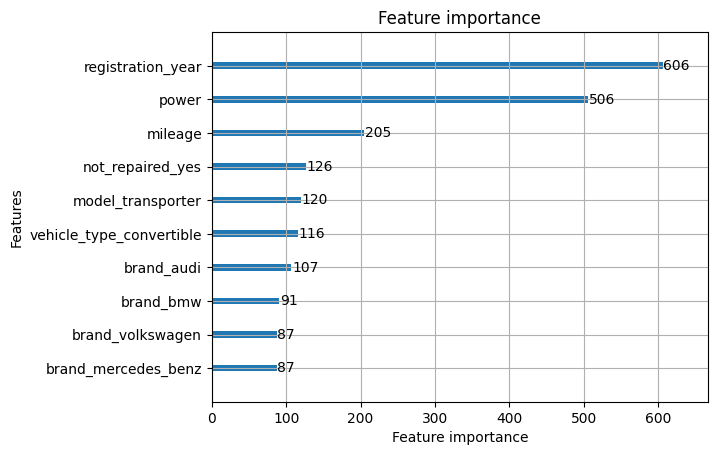

In [19]:
"""
docs:
https://lightgbm.readthedocs.io/en/latest/Parameters.html
https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py
"""
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_valid,y_valid)

lgb_params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
}

lgb_model = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval, callbacks=[lgb.early_stopping(stopping_rounds=5)])

lgb_predictions = lgb_model.predict(x_valid, num_iteration=lgb_model.best_iteration)

rmse = sklearn.metrics.mean_squared_error(y_valid, lgb_predictions, squared=False)
print(f'RMSE: {rmse:.2f}')

#Grafico de features mas importantes
feature_importances = lgb_model.feature_importance(importance_type='split')
feature_names = lgb_model.feature_name()

plt.figure(figsize=(10, 6))
lgb.plot_importance(lgb_model, importance_type='split', max_num_features=10)
plt.show()

#### XGBOOST

c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 2085.20


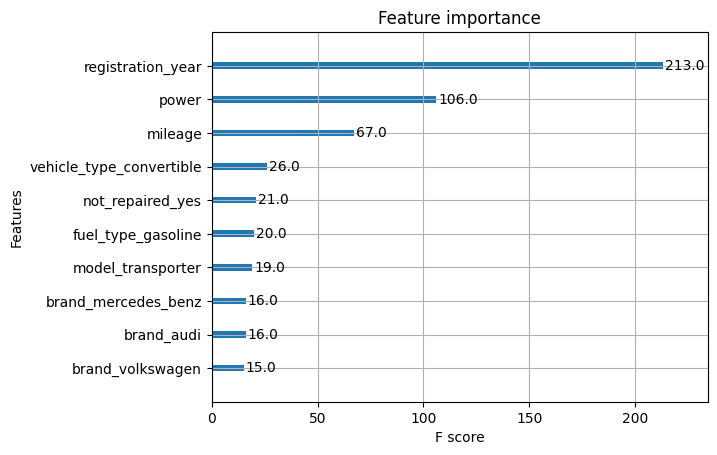

In [20]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=3)

xgb_model.fit(x_train, y_train)

xgb_predictions = xgb_model.predict(x_valid)

rmse = sklearn.metrics.mean_squared_error(y_valid, xgb_predictions, squared=False)
print(f'RMSE: {rmse:.2f}')

#Grafico de features mas importantes
xgb.plot_importance(xgb_model, max_num_features= 10)
plt.show()

#### CATBOOST

0:	learn: 4711.8105009	total: 171ms	remaining: 2m 50s


200:	learn: 2079.9204881	total: 6.06s	remaining: 24.1s
400:	learn: 1962.5174488	total: 11.5s	remaining: 17.2s
600:	learn: 1902.5830803	total: 17.1s	remaining: 11.4s
800:	learn: 1862.6056761	total: 22.8s	remaining: 5.65s
999:	learn: 1832.8808467	total: 28.1s	remaining: 0us
RMSE: 1842.70


c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


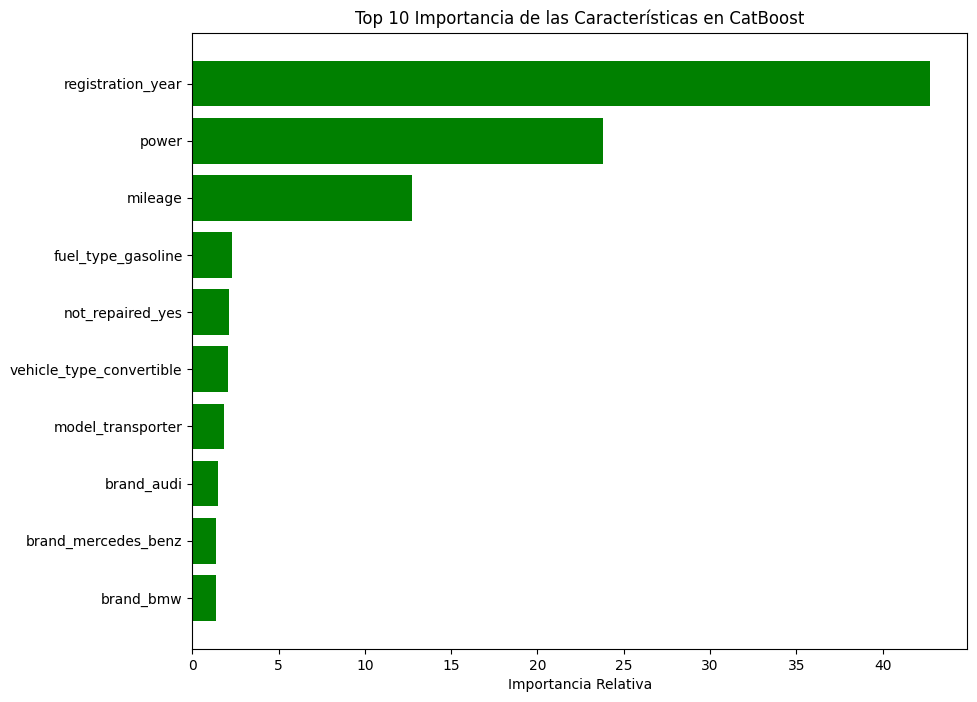

In [21]:
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='RMSE',
    verbose=200
)

cat_model.fit(x_train, y_train)
cat_predictions = cat_model.predict(x_valid)

rmse = sklearn.metrics.mean_squared_error(y_valid, cat_predictions, squared=False)
print(f'RMSE: {rmse:.2f}')

feature_importances = cat_model.get_feature_importance()
features = x_train.columns

indices = np.argsort(feature_importances)[-10:]

plt.figure(figsize=(10, 8)) 
plt.title('Top 10 Importancia de las Características en CatBoost')
plt.barh(range(len(indices)), feature_importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importancia Relativa')
plt.show()

## Análisis del modelo

#### REGRESION LINEAL

c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 2777.87


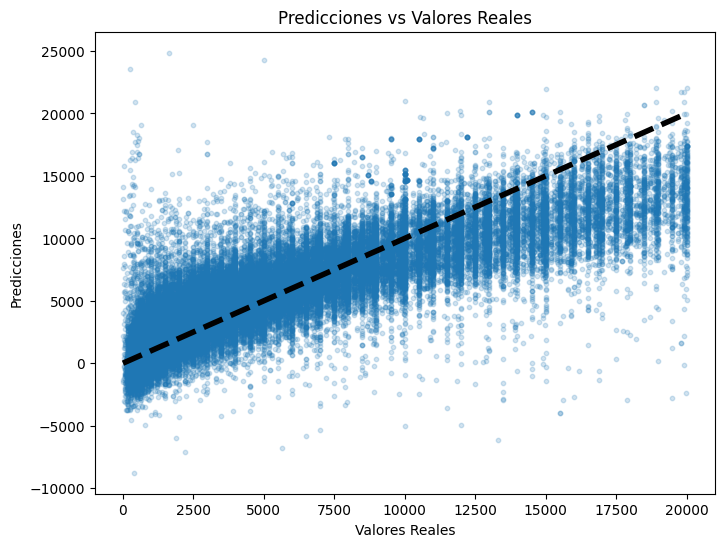

In [22]:
rmse = sklearn.metrics.mean_squared_error(y_valid, lr_predictions, squared=False)
print(f'RMSE: {rmse:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_valid, lr_predictions, s=10, alpha=0.2)  # Ajustar el tamaño y la transparencia de los puntos
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')

# Dibujar la línea diagonal
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=4)

plt.show()

#### BOSQUE ALEATORIO

c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 1732.76


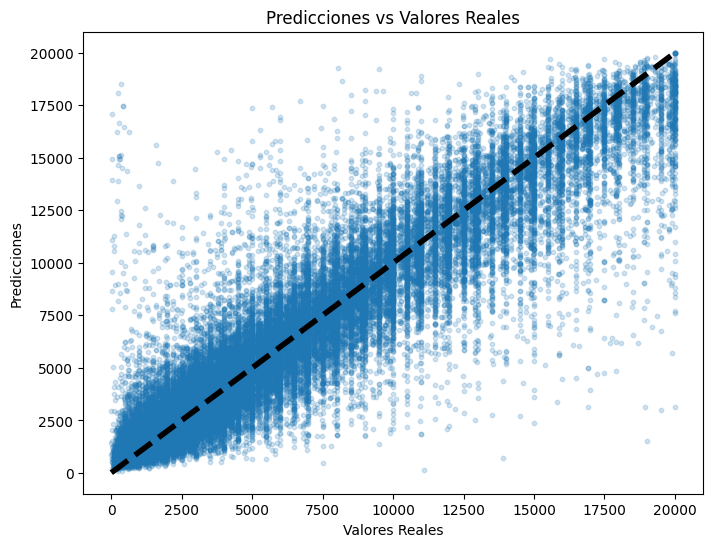

In [23]:
rmse = sklearn.metrics.mean_squared_error(y_valid, rf_predictions, squared=False)
print(f'RMSE: {rmse:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_valid, rf_predictions, s=10, alpha=0.2)  # Ajustar el tamaño y la transparencia de los puntos
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')

# Dibujar la línea diagonal
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=4)

plt.show()

#### LIGHTGBM

c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 1929.70


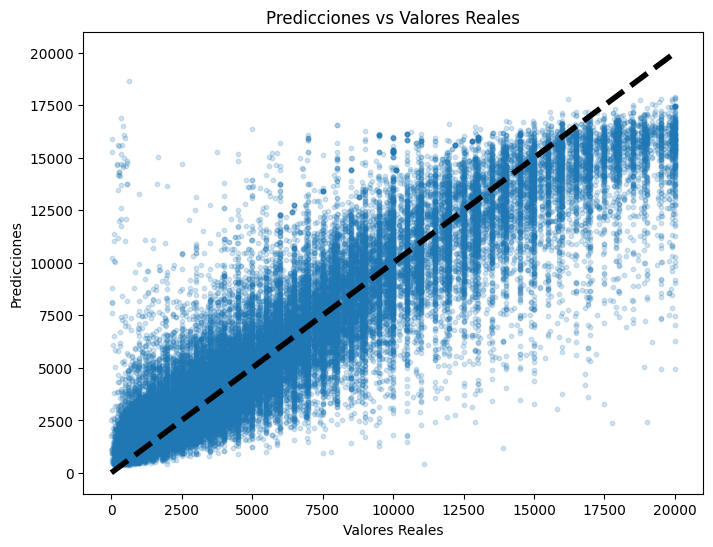

In [24]:
rmse = sklearn.metrics.mean_squared_error(y_valid, lgb_predictions, squared=False)
print(f'RMSE: {rmse:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_valid, lgb_predictions, s=10, alpha=0.2)  # Ajustar el tamaño y la transparencia de los puntos
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')

# Dibujar la línea diagonal
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=4)

plt.show()

#### XGBOOST

c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 2085.20


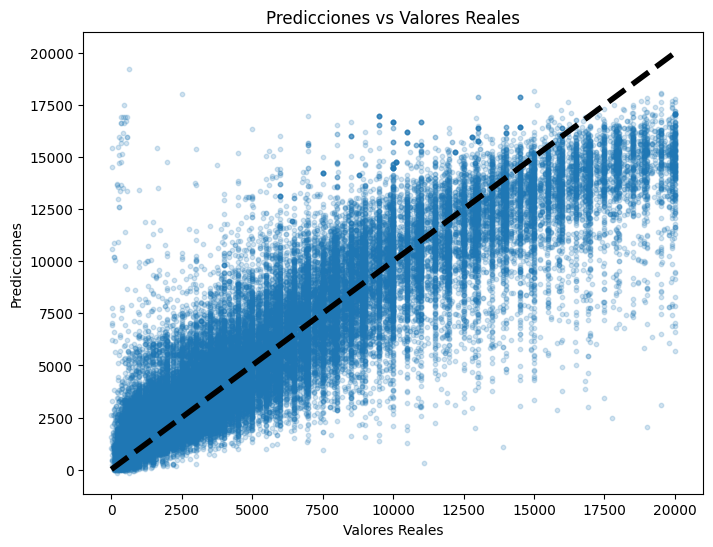

In [25]:
rmse = sklearn.metrics.mean_squared_error(y_valid, xgb_predictions, squared=False)
print(f'RMSE: {rmse:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_valid, xgb_predictions, s=10, alpha=0.2)  # Ajustar el tamaño y la transparencia de los puntos
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')

# Dibujar la línea diagonal
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=4)

plt.show()

#### CATBOOST

c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 1842.70


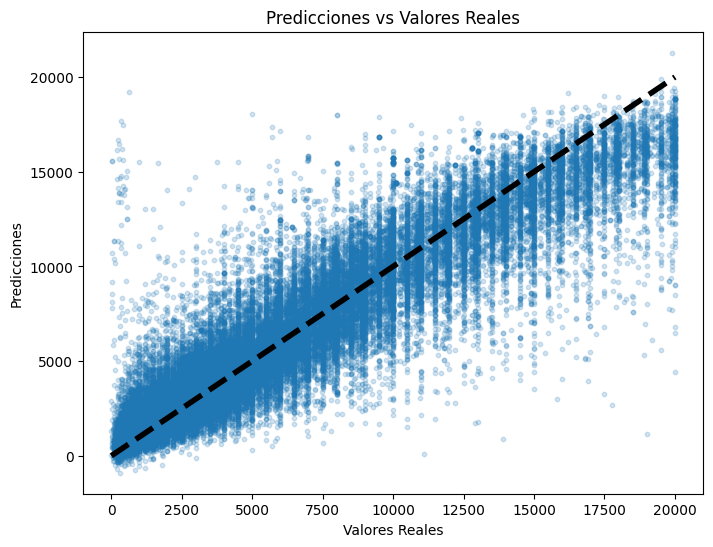

In [26]:
rmse = sklearn.metrics.mean_squared_error(y_valid, cat_predictions, squared=False)
print(f'RMSE: {rmse:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_valid, cat_predictions, s=10, alpha=0.2)  # Ajustar el tamaño y la transparencia de los puntos
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')

# Dibujar la línea diagonal
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=4)

plt.show()

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos